In [1]:
# Import pymsg

import sys
import os
sys.path.insert(0, os.path.join(os.environ['MSG_DIR'], 'lib'))
import pymsg

# Import standard modules and configure them

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams.update({'font.size': 16})

In [2]:
import h5py
from scipy import interpolate as inp
from scipy.integrate import quad as integrate
from scipy.special import legendre, lpmv, sph_harm
from scipy.optimize import fsolve

import f90nml as nml
from shutil import copyfile

from PyAstronomy import pyasl
from astropy.io import ascii
import ipywidgets as ipw

In [3]:
pg = pymsg.PhotGrid('pg-demo-kepler.h5')

In [4]:
# must have atm_coeffs.py and resp_coeffs.py 
# in notebook directory

import atm_coeffs as ac
import resp_coeffs as rc

In [5]:
atms = ac.atm_coeffs('lc-data/iOri-partials.h5')

In [8]:
def read_johnson_filter (filter_path, w_0, dw, n_w):
    
    f = open(filter_path, "r") 
    f_lines = f.readlines()
    f.close()
    
    # Evaluate the center wavelength of the bins

    w_range = w_0 + 0.5*dw + np.arange(n_w)*dw
    
    # Read wavelengths and convert from nm to w=log(Angstroms)
    
    w = np.log(10.0*np.array([float(i.split()[0]) for i in f_lines[1:-1]])[::-1])
    
    # Read filter response and convert from percentage to decimal
    
    response = 1.0e-2*np.array([float(i.split()[1]) for i in f_lines[1:-1]])[::-1]
    
    # Interpolate respone function onto spectral abscissa
    
    filter_func = inp.interp1d(
        w, response, bounds_error=False, fill_value=0)
    
    filter_pass = filter_func( w_range )
    
    return filter_pass

In [9]:
##### Pass specific intensity through filter 'x'

def eval_I_x (I_w, filter_path, w_0, dw, n_w, debug=False):
   
    # Read filter 
   
    filter_pass = read_johnson_filter(filter_path, w_0, dw, n_w)
   
    # Pass specific intensity from angle mu through filter
   
    I_w_filter = np.multiply(I_w, filter_pass)
    
    # Evaluate spectral range
    
    w_range = w_0 + 0.5*dw + np.arange(n_w)*dw
    
    lambda_range = np.exp(w_range)
    
    # Convert flux from per-unit-w to per-unit-lambda
    
    I_filter = I_w_filter/lambda_range
    
    if debug==True:
        
        return I_filter
    
    else:
    
        I_x = np.trapz( I_filter, lambda_range )
    
        return I_x
    

In [10]:
##### Extract from filtered intensity (colors) moment 'l'

def eval_I_x_l (sg, dx, l_range, filter_path, w_0, dw, n_w, debug=False):
    
    # Construct high resolution abscissa to integrate over
    
    mu_range = np.linspace(0, 1, 3000)
    
    # Construct dixt of filtered intensity moments 
    
    I_x_l = {}
    dI_dlnT_x_l = {}
    dI_dlng_x_l = {}
    
    # Construct I_x(mu)_i array shaped like N(mu_range)*N(l_range)
    
    for i, l in enumerate(l_range):
        
        # Evaluate I_x over all mu for moment l
        
        I_w_mu = [sg.intensity(dx, mu, w_0, n_w) for mu in mu_range]
        dI_dlnT_w_mu = [sg.intensity(dx, mu, w_0, n_w, {'logT': True})*np.log10(np.e) for mu in mu_range]
        dI_dlng_w_mu = [sg.intensity(dx, mu, w_0, n_w, {'logg': True})*np.log10(np.e) for mu in mu_range]
    
        I_x_mu = [eval_I_x( ii , filter_path, w_0, dw, n_w) for ii in I_w_mu]
        dI_dlnT_x_mu = [eval_I_x( ii , filter_path, w_0, dw, n_w) for ii in dI_dlnT_w_mu]
        dI_dlng_x_mu = [eval_I_x( ii , filter_path, w_0, dw, n_w) for ii in dI_dlng_w_mu]
        
        # Create legendre polynomial function for moment l

        P = legendre(l)

        # Find intensity moment I_x_l

        I_x_l[l] = np.trapz(mu_range*I_x_mu*P(mu_range), mu_range)
        dI_dlnT_x_l[l] = np.trapz(mu_range*dI_dlnT_x_mu*P(mu_range), mu_range)
        dI_dlng_x_l[l] = np.trapz(mu_range*dI_dlng_x_mu*P(mu_range), mu_range)

    return I_x_l, dI_dlnT_x_l, dI_dlng_x_l

In [11]:
class star:
    
    def __init__ (self, list_path, star_number, x):
        
        # should check if 'inlist', this just checks 'str'
        
        if isinstance(list_path, str):
            self.nml = nml.read(list_path)[f'star_{star_number}']
        else: raise Exception('Inlist file error')
            
        self.par = self.read_mesa_params(self.nml['star_model_path'])
        
        self.res = rc.resp_coeffs(self.nml['tide_model_path'])
        
        self.atm = self.read_atm_coeffs(self.nml['star_model_path'], x)
        
            
    def read_mesa_params(self, mesa_model_path, units='SOLAR'):
        
        data = ascii.read(mesa_model_path, data_start=0, data_end=1)
        
        # cgs constants
        
        R_sol = 6.957e10 
        M_sol = 1.989e33
        L_sol = 3.839e33
        G = 6.674079999999999e-08 
        sigma_sb = 5.6703669999999995e-05
        
        # data in cgs
        
        m = data[0][1]
        r = data[0][2]
        l = data[0][3]
            
        # calculate Teff [K], logg [dex]
        
        Teff = (l/(sigma_sb * 4*np.pi*r**2))**0.25
        
        g_surf = G*m/(r**2)
        
        logg = np.log10(g_surf)
        
        # convert to solar units
        
        if units=='SOLAR':
            m = m/M_sol
            r = r/R_sol
            l = l/L_sol
            
        return {'M': m,
                'R': r,
                'L': l,
                'Teff': Teff,
                'logg': logg}
            
            
    def read_atm_coeffs(self, inlist, x):
        
        # Set atmosphere parameters dict
    
        Teff = self.par['Teff']
        logg = self.par['logg']

        dx = {'logT': np.log10(Teff), 'logg': logg}
        sg = pymsg.SpecGrid('sg-demo.h5')

        # Set wavelength bounds

        lambda_min = 3000.
        lambda_max = 7000.

        # Set up corresponding w bounds

        w_min = np.log(lambda_min)
        w_max = np.log(lambda_max)

        # Set up spectral abscissa values

        w_0 = w_min
        dw = sg.dw
        n_w = np.ceil((w_max - w_min)/dw)
        
        # Set up intensity moment range
        
        l_min = 0
        dl = 1
        l_max = self.res.data['l_max']
        n_l = np.ceil( (l_max - l_min)/dl ) + 1

        l_range = l_min + dl*np.arange(n_l)
        
        # Evaluate photometric data

        I_x_l, dI_dlnT_x_l, dI_dlng_x_l = eval_I_x_l(sg, dx, l_range, '../filters/'+x+'.txt', w_0, dw, n_w)
        
        #atm = atm_coeffs(Teff,logg)
        
        #return ac.atm_coeffs('lc-data/iOri-partials.h5')
        
        return {f'I_{x}': I_x_l, f'dI_dlnT_{x}': dI_dlnT_x_l, f'dI_dlng_{x}': dI_dlng_x_l}

In [12]:
class binary:
    
    def __init__ (self, list_path, x):
        
        # should check if 'inlist', this just checks 'str'
        
        if isinstance(list_path, str):
            self.nml = nml.read(list_path)
        else: raise Exception('Inlist file error')
        
        self.star = {1: star(list_path, 1, x),\
                     2: star(list_path, 2, x) }
        
        self.orbit = self.read_orbit(self.nml)
            
        
    def read_orbit(self, inlist):
        
        orb_list = inlist['orbit']
        
        params = {}
        
        #placeholder unit routine
        
        if orb_list['omega_orb_units']=='CYC_PER_DAY':
            omega_orb_units = 1 
        else: omega_orb_units = 1
        
        if orb_list['a_units']=='CM':
            a_units = 6.957e10 #cm per r_sol
        else: a_units = 1
            
        # eventually, we want to get these from resp_data
        # resp_data currently does not contain this output tho
        
        params['a'] = orb_list['a']*a_units
        params['e'] = orb_list['e']
        params['Omega_orb'] = orb_list['omega_orb']*omega_orb_units
        
        return params

In [13]:
class irradiation:
    
    def __init__ (self, bin_data, star_number):
        
        # prep for find_bin_sep()
        
        self.e = bin_data.orbit['e']
        self.a = bin_data.orbit['a']
        self.Omega_orb = bin_data.orbit['Omega_orb']
        
        # prep for eval_irrad()
        
        if int(star_number)==1:
            star_neighbor = 2
        elif int(star_number)==2:
            star_neighbor = 1
        else:
            raise Exception('Star unspecified')
        
        self.atm_data = bin_data.star[star_number].atm
        self.res_data = bin_data.star[star_number].res.data
        
        self.L1 = bin_data.star[star_number].par['L']
        self.R1 = bin_data.star[star_number].par['R']
        self.L2 = bin_data.star[star_neighbor].par['L']
        
            
    def eval_ramp (self, l, m):
        
        term1 = 2* np.sqrt( ((2*l+1)/(4*np.pi)) \
                           *(np.math.factorial(l-m)/np.math.factorial(l+m)) )
        
        if (np.abs(m)==1):
            term2 = np.pi/2
        else:
            term2 = np.cos(m*np.pi/2)/(1-m**2)
        
        # Can I do this integral using symbolic mu, (as I do below)
        # or should I stick to integrating only those mu which I have data for?
        
        term3, term3_err = integrate(lambda mu: np.sqrt(1-mu**2)*lpmv(m,l, mu), -1, 1)
        
        Z_lm = term1*term2*term3
        
        return Z_lm
    
    
    def find_disk_intg_factor (self, l, x):
        
        # I still don't know if I need a bandpass correction, or if defining b_l
        # using the bandpass corrected intensities (as I do here) is sufficient.
    
        b_l = self.atm_data[f'I_{x}'][l]/self.atm_data[f'I_{x}'][0]
    
        return b_l
        
    
    def find_mean_anom (self, t, t_peri=0):
        
        return self.Omega_orb*(t - t_peri)*(2*np.pi)
        
    
    def find_ecce_anom (self, M):
    
        K_soln = np.empty_like(M)
        
        for i, M_val in enumerate(M):
            
            Keppler = lambda E : E - self.e*np.sin(E) - M_val
            K_soln[i] = fsolve(Keppler, 0)[0]
        
        return K_soln
        
    
    def find_true_anom (self, E):
    
        return 2*np.arctan( ((1+self.e)/(1-self.e))*np.tan(E/2) )
    
    
    def convert_t_to_f (self, t, t_peri=0):
    
        M = self.find_mean_anom(t, t_peri)
        
        E = self.find_ecce_anom(M)
        
        f = self.find_true_anom(E)
        
        return f
    
    
    def find_bin_sep (self, t, t_peri=0):
        
        f = self.convert_t_to_f(t, t_peri)#* 2*np.pi
        
        D = self.a*(1-self.e**2)/(1+self.e*np.cos(f))
        
        return D
    
    
    def find_irrad (self, x, t, t_peri=0):
        
        Dt = self.find_bin_sep(t, t_peri)
        
        #rel_dJm = np.zeros(self.res_data['l_max']+1, dtype=complex)
        
        rel_dJ = np.zeros_like(t)
        
        n_l = self.res_data['l_max']
        
        for l in range(2, n_l+1):
            for m in range(-l, l+1):
                
                Z_lm = self.eval_ramp(l, m)
                b_l = self.find_disk_intg_factor(l, x)
                #rel_dJm[m] += b_l*Z_lm*(self.L2/self.L1)
                rel_dJ += b_l*Z_lm*(self.L2/self.L1)*(self.R1/Dt)**2
        
        return rel_dJ
        
            #dJ/unperturbed_observed_flux 
            # = bandpass_correction_coefficient*(L2/L1)*(R1/D(t))**2
            #   * disc_integral_factor_(Burkart_used_Eddington_limb_darkening)
            

In [14]:
class observer:
    
    def __init__ (self, list_path, x):
        
        if isinstance(list_path, str):
            self.nml = nml.read(list_path)
        else: raise Exception('Inlist file error')
    
        self.bin_data = binary(list_path, x)
        
        self.irr = {1: irradiation(self.bin_data, 1),\
                    2: irradiation(self.bin_data, 2)}
        
    
    def convert_coords (self, inc, omega):

        theta = inc/180 * np.pi
        phi = (90-omega)/180 * np.pi
        
        return theta, phi
        
    
    def calc_bol_I (self, I_0, l):
        
        if l == 0:
            I_l = 1
        elif l == 1:
            I_l = 1/3
        elif l == 2:
            I_l = 1/8
        elif l == 3:
            I_l = 0
        elif l == 4:
            I_l = -1/48
        elif l == 5:
            I_l = 0
        elif l == 6:
            I_l = 1/128
        else:
            raise Exception('No I_l defined')
            
        return I_l*I_0
            
    
    def eval_fourier (self, star_number, inc, omega, x, bol=False):
        
        res = self.bin_data.star[star_number].res
        atm = self.bin_data.star[star_number].atm
        
        theta, phi = self.convert_coords(inc, omega)
        
        # Initialize the frequencies/amplitudes arrays
        
        f = np.arange(res.data['k_max']+1)*res.data['Omega_orb']
        
        A = np.zeros(res.data['k_max']+1, dtype=complex)
            

        # Loop over l, m and k
        I = atm
    
        for l in range(2, res.data['l_max']+1):
            for m in range(-l, l+1):
                for k in range(0, res.data['k_max']+1):

                    i_l = l
                    i_m = m + res.data['l_max']
                    i_k = k

                    dR_lmk = res.R_lmk[i_l,i_m,i_k]
                    dT_lmk = res.T_lmk[i_l,i_m,i_k]
                    dG_lmk = res.G_lmk[i_l,i_m,i_k]

                    Y_lm = sph_harm(m, l, phi, theta)
                    
                    R_xl = (2 + l)*(1 - l)*I[f'I_{x}'][l] / I[f'I_{x}'][0]
                    T_xl = I[f'dI_dlnT_{x}'][l] / I[f'I_{x}'][0] 
                    G_xl = I[f'dI_dlng_{x}'][l] / I[f'I_{x}'][0]
                    
                    if bol==True:
                        I_l = self.calc_bol_I( I[f'I_{x}'][0], l)
                        R_xl = (2 + l)*(1 - l)*I_l / I[f'I_{x}'][0]
                        T_xl = 4*I_l / I[f'I_{x}'][0]
                        G_xl = 0
                    
                    if k == 0:
                        if m == 0:
                            kappa = 0.5
                        elif m >= 1:
                            kappa = 1.
                        else:
                            kappa = 0.
                    else:
                        kappa = 1.
    
                    # Add the Fourier contribution * spherical harmonic
                    
                    A[i_k] += 2*kappa*(dR_lmk*R_xl + dT_lmk*T_xl + dG_lmk*G_xl)*Y_lm
        
        # Return data
        
        return f, A
    

    def find_star_flux (self, star_number, inc, omega, x, t, t_peri=0, bol=False):
        
        res = self.bin_data.star[star_number].res
        Omega_orb = self.bin_data.orbit['Omega_orb']
        
        f, A = self.eval_fourier(star_number, inc, omega, x, bol)
        
        # Initialize the frequencies/amplitudes arrays
        
        if isinstance(t, np.ndarray):
            
            star_flux = np.zeros_like(t)
        
        elif isinstance(t, list):
            
            t = np.array(t)
            star_flux = np.zeros_like(t)
            
        else: #How to isinstance any mathable t? float, int, etc?
            
            star_flux = 0.

        # Add contributions from each frequency component

        n_A = len(A)

        for i in range(n_A):
            
            star_flux += np.real(A[i] * np.exp(-1j*f[i]*2*np.pi*(t - t_peri)))
            
        return star_flux
    
    
    def find_flux (self, inc, omega, x, t, t_peri=0, reflection=True, bol=False):
        
        star_1 = self.find_star_flux(1, inc, omega, x, t, t_peri, bol)
        star_2 = self.find_star_flux(2, inc, omega, x, t, t_peri, bol)
        
        if reflection==False:
            return star_1 + star_2
        
        else:
            irr_1 = self.irr[1].find_irrad(x, t, t_peri)
            irr_2 = self.irr[2].find_irrad(x, t, t_peri)
        
            return irr_1 + irr_2 + star_1 + star_2
    

In [294]:
def run_observer(bin_list):
    
    # Setup observer
    
    obs = observer(bin_list)
    
    inc = obs.nml['orbit']['inc']
    omega = obs.nml['orbit']['omega']
    t_units = 1/obs.nml['orbit']['Omega_orb']
    
    x = obs.nml['observer']['bandpass']
    t_start = obs.nml['observer']['t_start']*t_units
    t_end = obs.nml['observer']['t_end']*t_units
    n = obs.nml['observer']['n']
    
    t_ = np.linspace(t_start, t_end, n)

    # Evaluate fourier terms

    return obs.find_flux(inc, omega, x, t_) 



In [23]:
# Evaluate fourier terms

inc = 82.9
omega = 122.2
x = 'BRITE-B'

obs1 = observer('bin_params.in', 'BRITE-B')
obs2 = observer('bin_params.in', 'BRITE-R')
omega_orb = obs1.nml['orbit']['Omega_orb']

t = np.linspace(-1.5/omega_orb, 2.5/omega_orb, 2000)

flux_1 = obs1.find_flux(inc, omega, 'BRITE-B', t) 
flux_2 = obs2.find_flux(inc, omega, 'BRITE-R', t) 

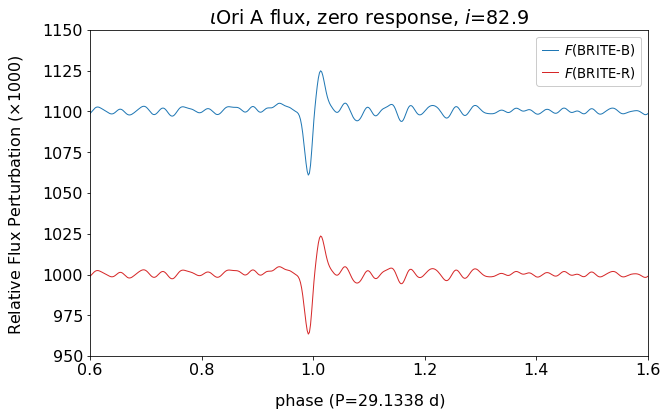

In [45]:
# Plot
fig, ax = plt.subplots(1,1, sharex=True, sharey=True, figsize=(10,6))#, dpi=100)

ax.plot(t*omega_orb, (flux_1 + 1.1)*1000, c='C0', lw=1, label=r'$F$(BRITE-B)')
ax.plot(t*omega_orb, (flux_2 + 1.0)*1000, c='C3', lw=1, label=r'$F$(BRITE-R)')

ax.set_xlim(0.6,1.6)
ax.set_ylim(0.95*1000,1.15*1000)

legend_style = {'framealpha':1.0, 'handlelength':1.2, 'handletextpad':0.5, 'fontsize':'small'}
ax.legend(loc=1, **legend_style)

ax.set_title(f'$\iota$Ori A flux, zero response, $i$={inc}')

fig.text(0.01, 0.5, r'Relative Flux Perturbation ($\times 1000$)', va='center', rotation='vertical')
fig.text(0.5, 0.01, f"phase (P={1./omega_orb:4.4f} d)", ha='center')

fig.savefig(f'iOri_response_msg.png')

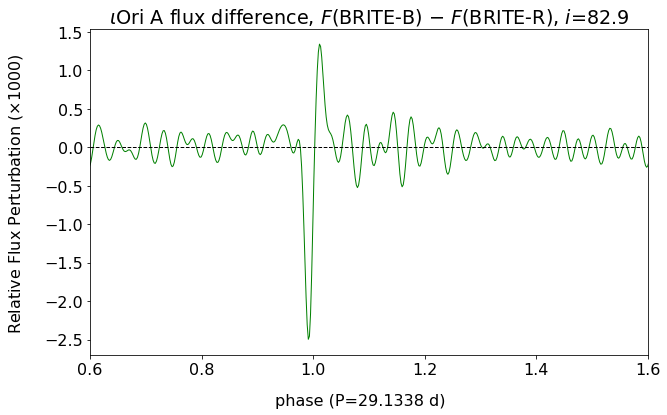

In [40]:
# Plot
fig, ax = plt.subplots(1,1, sharex=True, sharey=True, figsize=(10,6))#, dpi=100)

ax.plot(t*omega_orb, (flux_1-flux_2)*1000, c='g', lw=1)
ax.axhline(0, xmin=0,xmax=1, lw=1, ls='--', c='k')

ax.set_xlim(0.6,1.6)
#ax.set_ylim(0.95*1000,1.15*1000)

ax.set_title(f'$\iota$Ori A flux difference, $F$(BRITE-B) $-$ $F$(BRITE-R), $i$={inc}')

fig.text(0.01, 0.5, r'Relative Flux Perturbation ($\times 1000$)', va='center', rotation='vertical')
fig.text(0.5, 0.01, f"phase (P={1./omega_orb:4.4f} d)", ha='center')

fig.savefig(f'iOri_response_msg_difference.png')

In [25]:
f1, A1 = obs1.eval_fourier(1, inc, omega, 'BRITE-B')
f2, A2 = obs2.eval_fourier(2, inc, omega, 'BRITE-R')

In [26]:
fspace = np.linspace(0, 50, 501)
A1_space = np.zeros_like(fspace)
A2_space = np.zeros_like(fspace)

In [27]:
A1_space[0:451:10] = [np.abs(np.real(A1[int(i)])) for i in fspace[0:451:10]]
A2_space[0:451:10] = [np.abs(np.real(A2[int(i)])) for i in fspace[0:451:10]]

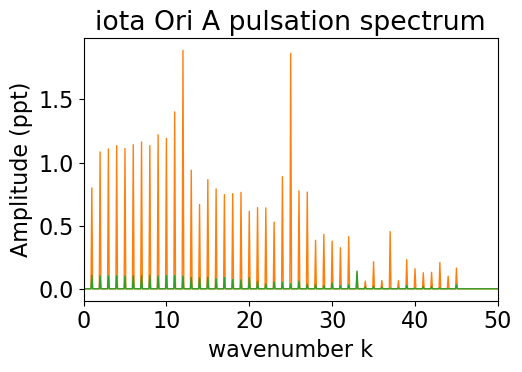

In [28]:
# Plot
fig, ax = plt.subplots(1,1, sharex=True, sharey=True, figsize=(5.5,4), dpi=100)

ax.plot(fspace, 1000*(A1_space), c='C1', lw=1)
ax.plot(fspace, 1000*(A2_space), c='C2', lw=1)

ax.set_xlim(0,50)
#ax.set_ylim(0,10)

#legend_style = {'framealpha':1.0, 'handlelength':1.2, 'handletextpad':0.5, 'fontsize':'small'}
#ax.legend(loc=1, **legend_style)

ax.set_title('iota Ori A pulsation spectrum')

ax.set_ylabel('Amplitude (ppt)')
ax.set_xlabel("wavenumber k")

fig.tight_layout()
#fig.savefig(f'iOri_flux_spectrum.png')

# MSG

In [ ]:
# Create a new SpecGrid

pg = pymsg.PhotGrid('sg-demo-kepler.h5')

In [49]:
print('Atmosphere parameters:')
for i, axis_label in enumerate(sg.axis_labels):
    print(f'  {axis_label} ({sg.axis_minima[i]} -> {sg.axis_maxima[i]})')

print()

print('Spectral abcissa parameters:')
print(f'  w_0: {sg.w_0}')
print(f'   dw: {sg.dw}')
print(f'  n_w: {sg.n_w}')

Atmosphere parameters:
  logT (3.5440680443502757 -> 4.698970004336019)
  logg (0.0 -> 5.0)

Spectral abcissa parameters:
  w_0: 8.003028666384733
   dw: 0.001
  n_w: 852


In [110]:
# Set atmosphere parameters dict

dx = {'logT': np.log10(30890.), 'logg': 3.645}

# Set wavelength bounds

lambda_min = 3000.
lambda_max = 7000.

# Set up corresponding w bounds

w_min = np.log(lambda_min)
w_max = np.log(lambda_max)

# Set up spectral abscissa values

w_0 = w_min
dw = sg.dw
n_w = np.ceil((w_max - w_min)/dw)

In [111]:
# Evaluate the center wavelength of the bins

lambda_c = np.exp(w_0 + 0.5*dw + np.arange(n_w)*dw)

# Evaluate the flux; note the parameters!

F_w = sg.flux(dx, w_0, n_w)

# Convert flux from per-unit-w to per-unit-lambda

F_lambda = F_w/lambda_c

In [174]:
B = read_johnson_filter('../filters/BRITE-B.txt', w_0, dw, n_w)
print(np.sum(B))

160.58319648674257


In [175]:
##### Build class filter grid

In [234]:
I_w = sg.intensity(dx, mu, w_0, n_w)

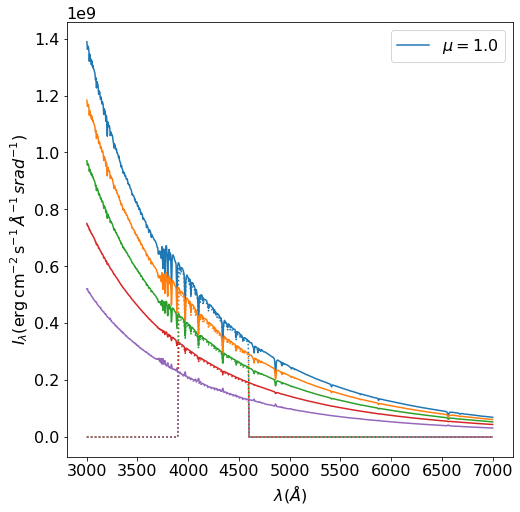

In [186]:
# Loop over mu

plt.figure(figsize=[8,8])

for i,mu in enumerate(np.linspace(1.0, 0.0, 5)):

    # Evaluate the intensity; note the parameters!

    I_w = sg.intensity(dx, mu, w_0, n_w)
    
    I_lambda = I_w/lambda_c

    I_x = eval_I_x(I_w, '../filters/BRITE-B.txt', w_0, dw, n_w, debug=True)

    # Plot

    if mu==0.1 or mu==1.0:
        label=r'$\mu={:3.1f}$'.format(mu)
    else:
        label=None

    plt.plot(lambda_c, I_lambda, label=label, c=f'C{i}')
    plt.plot(lambda_c, I_x, c=f'C{i}', ls=':')
    
plt.xlabel(r'$\lambda ({\AA})$')
plt.ylabel(r'$I_{\lambda} ({\rm erg\,cm^{-2}\,s^{-1}}\,\AA^{-1}\,srad^{-1})$')

plt.legend()

#plt.savefig('I_x_debug_mode.png')

In [243]:
l_min = 1
dl = 1
l_max = 4
n_l = np.ceil( (l_max - l_min)/dl ) + 1

l_range = l_min + dl*np.arange(n_l)

I_x_l, dI_dlnT_x_l, dI_dlng_x_l = eval_I_x_l(sg, dx, l_range, '../filters/BRITE-B.txt', w_0, dw, n_w)

In [244]:
print(I_x_l)
print(dI_dlnT_x_l)
print(dI_dlng_x_l)

{1.0: 87964245482.07422, 2.0: 40001299855.48776, 3.0: 7267347424.470581, 4.0: -2938709337.802342}
{1.0: 166116844089.40265, 2.0: 74926745510.98122, 3.0: 12786708277.961544, 4.0: -6322508379.989166}
{1.0: -1926297839.0540888, 2.0: -1433378189.0572414, 3.0: -737894424.9904517, 4.0: -133985978.46560672}


### intensity

In [182]:
help(sg)

Help on SpecGrid object:

class SpecGrid(builtins.object)
 |  A SpecGrid represents a grid of spectral intensity data.
 |  
 |  This grid may be used to interpolate the specific intensity (or
 |  related quantities) across a spatial (wavelength) abscissa and for
 |  a set of atmospheric parameter values Both internally and for
 |  interpolated results, the spatial abscissa is configured as a set
 |  of bins distributed uniformly in :math:`w`-space, where
 |  :math:`{\rm d}w`, where :math:`w \equiv
 |  \log(\lambda/\angstrom)`. Three parameters uniquely specify the
 |  abscissa: w_0, dw and n_w; the i'th bin (i=0,...,n_w-1) then spans
 |  the interval [w_0+i*dw, w_0+(i+1)*dw].
 |  
 |  Methods defined here:
 |  
 |  D_moment(self, dx, l, w_0, n_w, deriv)
 |      Evaluate the spectroscopic intensity moment :math:`D_{\ell}(w)`.
 |      
 |      Args:
 |          dx (dict): Atmospheric parameters; keys must match
 |              `axis_labels` property, values must be double.
 |          l 

# PHOEBE

In [ ]:
import phoebe

In [20]:
print(obs.bin_data.star[1].par)
print(obs.bin_data.star[2].par)
print(obs.bin_data.orbit)

{'M': 23.182330819507285, 'R': 11.999685653939883, 'L': 117782.65356264106, 'Teff': 30890.40961431762, 'logg': 3.6449995448967565}
{'M': 13.441351432880843, 'R': 4.6508146978180465, 'L': 14074.939028371045, 'Teff': 29173.288083715444, 'logg': 4.2315670480927166}
{'a': 132.0, 'e': 0.764, 'Omega_orb': 0.034324440099733095}


In [22]:
b=phoebe.default_binary()

In [32]:
b.set_value('q', value=0.5798)
b.set_value('period', component='binary', value=29.13376)
b.set_value('sma', component='binary', value=132.0)
b.set_value('incl', component='binary', value=82.9)
b.set_value('ecc', component='binary', value=0.764)

b.set_value('teff', component='primary', value=30890.40961431762)
#b.set_value('logg', component='primary', value=3.6449995448967565)

b.set_value('teff', component='secondary', value=29173.288083715444)
#b.set_value('logg', component='secondary', value=4.2315670480927166)

In [34]:
b.add_dataset('lc', times=phoebe.linspace(0,2,101))
b.add_dataset('rv', times=phoebe.linspace(0,2,101))
b.run_compute()
b.plot(x='phases', show=True)

ValueError: Could not lookup ld_coeffs for ld_coeffs_source_bol@primary@star@component.  Try changing ld_coeffs_source_bol to a table that covers a sufficient range of values or set ld_mode_bol to 'manual' and manually provide coefficients via ld_coeffs_bol. Enable 'warning' logger to see out-of-bound arrays.